<a href="https://colab.research.google.com/github/danielwisouza/Movie-Show-Advisor/blob/master/Movie_Show_Advisor_Analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando e Carregando Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.12


https://pypi.org

https://pypi.org/project/imdb-sqlite

In [4]:
# Instala o pacote
!pip install -q imdb-sqlite

Agora executamos o pacote para download dos datasets

In [5]:
# Instalar o pacote
# https://pypi.org/project/pycountry/
!pip install -q pycountry

     |████████████████████████████████| 10.1 MB 7.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [6]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
# tema para gráfico
sns.set_theme(style = "whitegrid") 

# Carregando os Dados

Primeiro temos que baixar os dados!

In [7]:
%%time
!imdb-sqlite

2022-03-23 12:46:01,840 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2022-03-23 12:46:05,617 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2022-03-23 12:46:07,837 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2022-03-23 12:46:09,875 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2022-03-23 12:46:12,742 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2022-03-23 12:46:13,824 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2022-03-23 12:46:14,041 Populating database: imdb.db
2022-03-23 12:46:14,042 Applying schema
2022-03-23 12:46:14,043 Importing file: downloads/name.basics.tsv.gz
2022-03-23 12:46:14,043 Reading number of rows ...
2022-03-23 12:46:21,985 Inserting rows into table: people
100% 11501001/11501001 [02:07<00:00, 90311.14 rows/s]
2022-03-23 12:4

In [8]:
# Conecta no banco de dados
conn = sqlite3.connect("imdb.db")

In [9]:
# Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM  sqlite_master  WHERE type = 'table'", conn)

In [10]:
# Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [11]:
# Visualiza o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [12]:
# Vamos Converter o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [13]:
# Vamos percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da Tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da Tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Agora começamos a Análise Exploratória dos Dados.

# 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

Quais são os principais tipos (categorias) dos títulos(filmes)?

In [14]:
# Cria a consulta SQl
consulta1 = '''SELECT  type, COUNT(*) AS COUNT FROM titles  GROUP BY type'''

In [15]:
# Extrai o resultado
resultado1 = pd.read_sql_query(consulta1,conn)

In [16]:
# Visualiza o resultado
display(resultado1)

,type,COUNT
0,movie,605229
1,short,861401
2,tvEpisode,6584067
3,tvMiniSeries,42657
4,tvMovie,135473
5,tvPilot,2
6,tvSeries,222561
7,tvShort,10509
8,tvSpecial,36370
9,video,258344


In [17]:
# Vamos calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [18]:
# Visualiza o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,605229,6.887547
1,short,861401,9.802802
2,tvEpisode,6584067,74.927128
3,tvMiniSeries,42657,0.485440
4,tvMovie,135473,1.541692
5,tvPilot,2,0.000023
6,tvSeries,222561,2.532759
7,tvShort,10509,0.119593
8,tvSpecial,36370,0.413893
9,video,258344,2.939972


In [19]:
# Vamos criar um gráfico com apenas 4 categorias:
# As 3 categorias com mais títulos e 1 categoria com todo o restate

# Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] =  resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajusta o nome
others['type'] = 'others'


In [20]:
# Visualiza
others

{'COUNT': 736597, 'percentual': 8.3825236756617, 'type': 'others'}

In [21]:
# Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [22]:
# Append com o datafgrame de outras categorias
resultado1 = resultado1.append(others, ignore_index= True)

In [23]:
# Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending= False)

In [24]:
# Visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6584067,74.927128
1,short,861401,9.802802
3,others,736597,8.382524
0,movie,605229,6.887547


In [25]:
# Ajustar os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

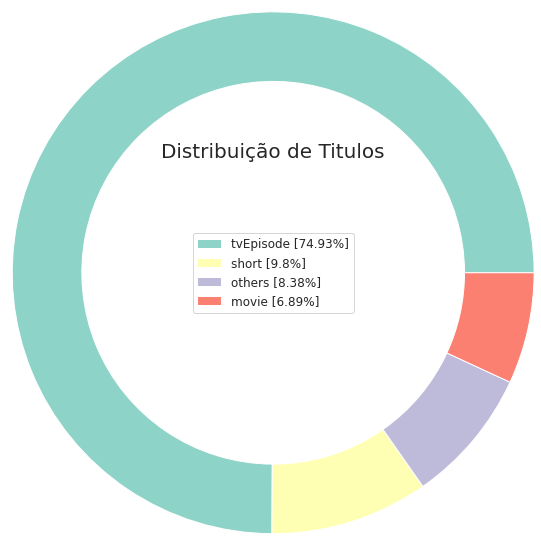

In [26]:
# Plot 

# Mapa de Cores
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Titulos", loc = 'Center', fontdict = {'fontsize': 20, 'fontweight': 20})
plt.show()

# 2- Qual o Número de Títulos Por Gênero?

Vamos calcular o número defilmes por gênero e entregar o resultado em valor percentual.

In [27]:
# Cria a consulta SQL
consulta2 = '''SELECT  genres, COUNT(*) FROM  titles  WHERE type = 'movie' GROUP BY genres'''

In [28]:
# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [29]:
# Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,13903
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1450,"Thriller,Western",44
1451,War,1292
1452,"War,Western",14
1453,Western,5155


In [30]:
# Converte as Strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [31]:
# Remove Valores NA (ausentes)
temp = resultado2['genres'].dropna()

Usamos o Countvectorizer para converter a coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero - matriz esparsa - para dados em string

In [32]:
# Vamos cirum vetor usando expressão regular para filtrar as strings
# https://docs.python.org/3/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#Convert a collection of text documents to a matrix of token counts - matriz esparsa
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [33]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [34]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [35]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [36]:
# Retorna generos únicos
generos_unicos = vetor.get_feature_names()

In [37]:
# Cria o data frame de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [38]:
# Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1454
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1455 non-null   int64
 1   adult        1455 non-null   int64
 2   adventure    1455 non-null   int64
 3   animation    1455 non-null   int64
 4   biography    1455 non-null   int64
 5   comedy       1455 non-null   int64
 6   crime        1455 non-null   int64
 7   documentary  1455 non-null   int64
 8   drama        1455 non-null   int64
 9   family       1455 non-null   int64
 10  fantasy      1455 non-null   int64
 11  film-noir    1455 non-null   int64
 12  game-show    1455 non-null   int64
 13  history      1455 non-null   int64
 14  horror       1455 non-null   int64
 15  music        1455 non-null   int64
 16  musical      1455 non-null   int64
 17  mystery      1455 non-null   int64
 18  n            1455 non-null   int64
 19  news         1455 non-null   int64
 20  reality-

In [39]:
# Drop Coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [40]:
# Calcula o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [41]:
# Visualiza
generos_percentual.head(10)

drama          18.144330
comedy         16.838488
documentary    15.807560
adventure      14.776632
action         14.432990
romance        13.264605
crime          13.127148
mystery        12.508591
thriller       12.302405
fantasy        12.096220
dtype: float64

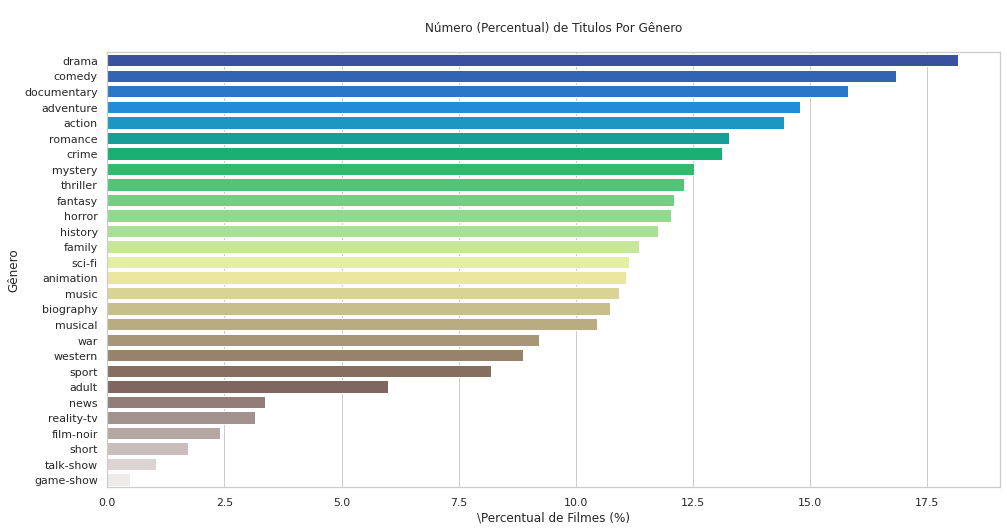

In [42]:
# Plot
plt.figure(figsize=(16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')
plt.xlabel("\Percentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Titulos Por Gênero\n')
plt.show()

# 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

Media de avaliação dos filmes

In [43]:
# Consulta SQL
consulta3 = '''
            SELECT  rating, genres  FROM 
            ratings 
            JOIN titles ON ratings.title_id = titles.title_id
            WHERE  premiered <= 2022 AND type = 'movie'
            '''

In [44]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [45]:
# Visualiza
display(resultado3)

,rating,genres
0,4.5,\N
1,6.0,"Action,Adventure,Biography"
2,4.6,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
276314,5.8,Thriller
276315,6.4,"Drama,History"
276316,3.8,"Adventure,History,War"
276317,8.3,Drama


In [46]:
# Vamos criar uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos
                    

In [47]:
# Aplica a função 
generos_unicos = retorna_generos(resultado3)

In [48]:
# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [49]:
# Cria lista Vazias
genero_counts = []
genero_ratings = []

In [50]:
# Loop
for item in generos_unicos:
   
   # Retorna a contagem de filmes por gênero
   consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
   resultado = pd.read_sql_query(consulta, conn)
   genero_counts.append(resultado.values[0][0])
 
    # Retorna a avaliação de filmes por gênero
   consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
   resultado = pd.read_sql_query(consulta, conn)
   genero_ratings.append(np.median(resultado['rating']))

In [51]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [52]:
# Visualiza
df_genero_ratings.head(20)

,genres,count,rating
0,action,28572,5.8
1,adult,4348,5.9
2,adventure,17335,6.0
3,animation,4751,6.6
4,biography,8371,7.0
5,comedy,68403,6.0
6,crime,23584,6.1
7,documentary,41089,7.3
8,drama,122353,6.3
9,family,10683,6.3


In [53]:
# Drop do índice 18 (news)
# Não queremmos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [54]:
# Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values( by = 'rating', ascending = False)

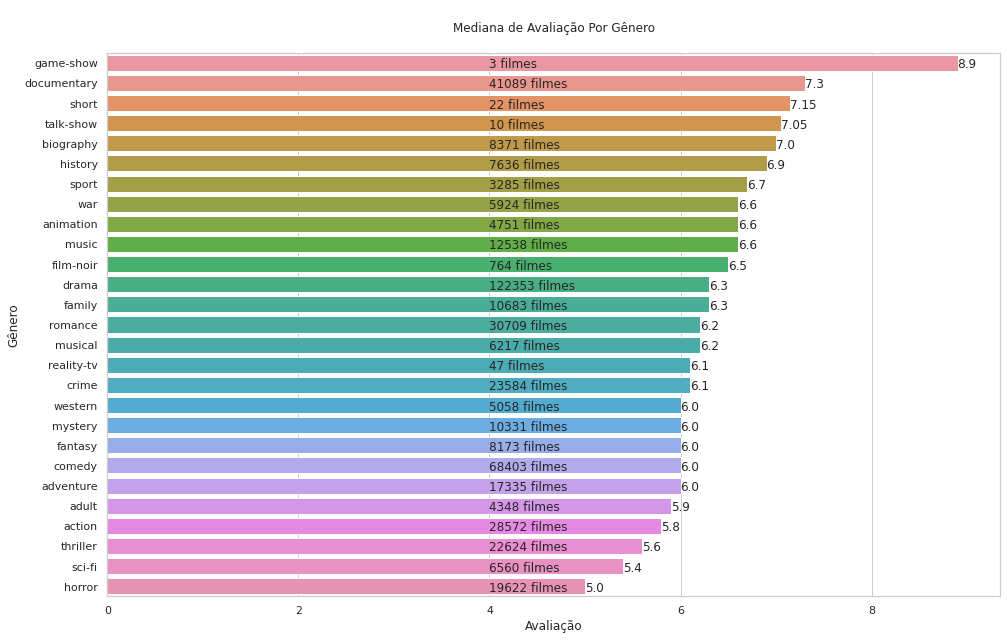

In [55]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0,
            i + 0.25,
            str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
            i + 0.25,
            round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))
plt.ylabel('Gênero')
plt.xlabel('Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

# 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Mediana de avaliação dos Filmes.

In [56]:
# Consulta SQL
consulta4 = '''
            SELECT  rating AS Rating, premiered FROM
            ratings 
            JOIN titles ON ratings.title_id = titles.title_id
            WHERE  premiered <= 2022 AND  type = 'movie'
            ORDER BY  premiered
            '''

In [57]:
# Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [58]:
display(resultado4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
276314,9.2,2022
276315,5.5,2022
276316,6.0,2022
276317,5.1,2022


In [59]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [60]:
type(ratings)

list

In [61]:
display(resultado4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
276314,9.2,2022
276315,5.5,2022
276316,6.0,2022
276317,5.1,2022


In [62]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [63]:
type(ratings)

list

In [64]:
ratings[1:10]

[4.5, 3.85, 5.85, 6.3, 3.5, 4.6, 5.3, 4.5, 3.6]

In [65]:
# Lsita de anos
anos = list(set(resultado4['premiered']))

In [66]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

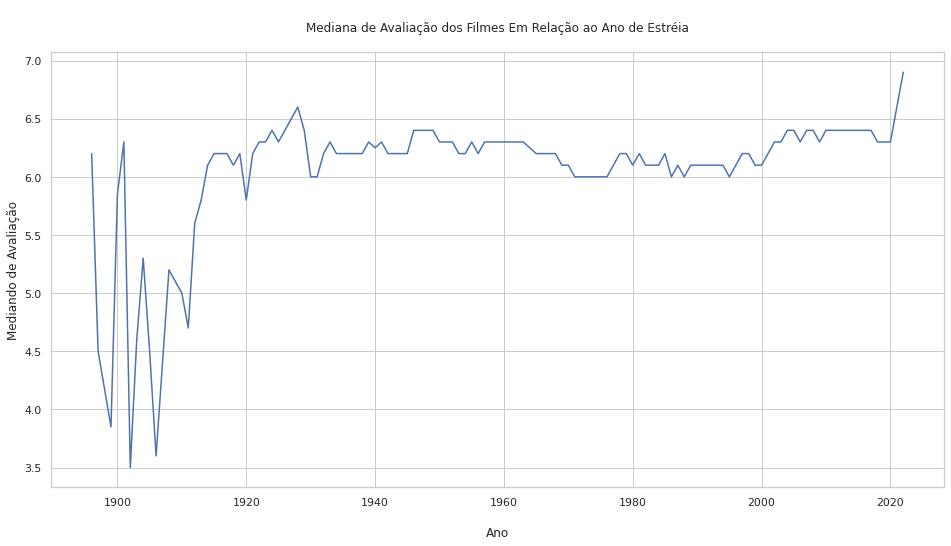

In [67]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos,ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediando de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

# 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Número de filmes por gênero. Vamos listar os Top 5.

In [68]:
# Consulta SQL
consulta5 = '''SELECT genres FROM titles'''

In [69]:
# Resultado
resultado5 = pd.read_sql_query(consulta5, conn)

In [70]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8787289,"Action,Drama,Family"
8787290,"Action,Drama,Family"
8787291,"Action,Drama,Family"
8787292,Short


In [71]:
# Retorna gêneros únicos
generos_unicos = retorna_generos(resultado5)

In [72]:
# Visualiza o generos únicos

generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [73]:
# Agora fazemos a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [74]:
genero_count

[41336,
 8354,
 22355,
 6745,
 13617,
 90992,
 30700,
 105610,
 191513,
 14975,
 11349,
 766,
 16,
 11930,
 25067,
 19555,
 9194,
 13632,
 1367,
 422,
 41100,
 8528,
 53,
 5789,
 133,
 29746,
 8178,
 7272]

In [75]:
# Prepara o Data frame
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [76]:
# Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values
# função head retorna os 5 primeiros

In [77]:
df_genero_count

,genre,Count
8,drama,191513
7,documentary,105610
5,comedy,90992
0,action,41336
20,romance,41100
6,crime,30700
25,thriller,29746
14,horror,25067
2,adventure,22355
15,music,19555


In [78]:
top_generos

array(['drama', 'documentary', 'comedy', 'action', 'romance'],
      dtype=object)

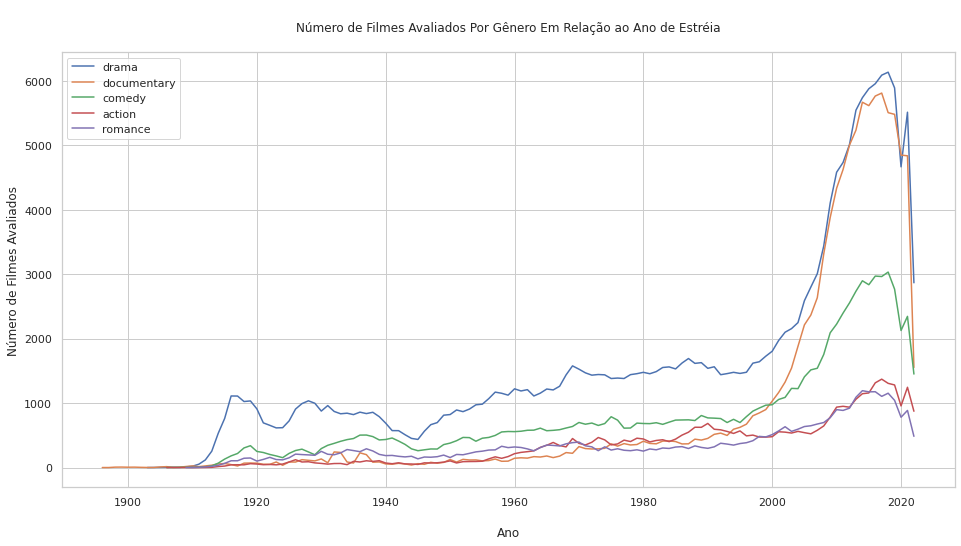

In [79]:
# Plot

# Figura
plt.figure(figsize = (16,8))

#Loop e Plot
for item in top_generos: 
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()
    

# 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

Percetins e o filme mais longo da história.

In [80]:
# Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime
            FROM  titles
            WHERE  type = 'movie' AND Runtime != 'NAN'
           '''

In [81]:
# Resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [82]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
380787,123
380788,57
380789,100
380790,116


In [83]:
# Loop para cálculo dos percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val),2 )
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 72.0
24 

percentil: extração dos dados e divisão em 100 partes iguais e para cada parte é calculado a porcentagem.

O percentil 100:  um outlier é um valor que foge da normalidade e que pode (e provavelmente irá) causar anomalias nos resultados obtidos por meio de algoritmos e sistemas de análise.

In [84]:
# Refazendo a consulta e teronado o filme com maior duração
consulta6 = '''
            SELECT  runtime_minutes Runtime, primary_title
            FROM  titles
            WHERE type =  'movie' AND Runtime != 'Nan'
            ORDER BY Runtime DESC
            LIMIT 1
            '''

In [85]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [86]:
resultado6

,Runtime,primary_title
0,51420,Logistics


Logistics, ou Logistics Art Project, é um filme experimental sueco de 2012 concebido e criado por Erika Magnusson e Daniel Andersson. Com 51.420 minutos, é o filme mais longo já feito.

# 7- Qual a Relação Entre Duração e Gênero?

Relação entre duração do filme e gênero

In [87]:
# Consulta SQL
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres
            FROM titles
            WHERE  type = 'movie'
            AND runtime_minutes != 'Nan'
            GROUP BY genres
            '''

In [88]:
# Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [89]:
# Retorna gênros únicos
generos_unicos = retorna_generos(resultado7)

In [90]:
# Calcula duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [91]:
# Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [92]:
# Remove índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index=18)

In [93]:
# Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending=False)

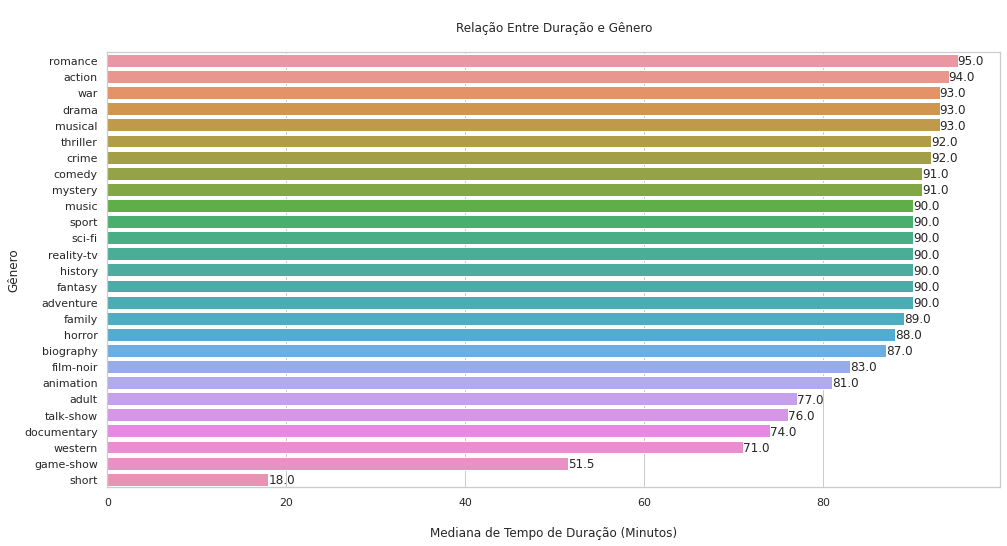

In [94]:
# Plot

# Tamanho da Figura
plt.figure(figsize=(16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
            i + 0.25,
            round(df_genero_runtime["runtime"][df_genero_runtime.index[i]],2))
    
plt.ylabel('Gênero')    
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

# 8- Qual o Número de Filmes Produzidos Por País?

Número de filmes produzidos por país.

In [95]:
# Consulta sql
consulta8 = '''
            SELECT region,COUNT(*) Number_of_movies 
            FROM akas
            JOIN  titles ON akas.title_id = titles.title_id
            WHERE region != 'None'
            GROUP BY region
            '''

In [96]:
# Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [97]:
display(resultado8)

,region,Number_of_movies
0,AD,47
1,AE,11381
2,AF,247
3,AG,20
4,AI,5
...,...,...
242,YUCS,702
243,ZA,7725
244,ZM,54
245,ZRCD,6


In [98]:
# Shape
resultado8.shape

(247, 2)

In [99]:
# Número de linhas
resultado8.shape[0]

247

In [100]:
# Lista Auxiliares
nomes_paises = []
contagem = []

In [101]:
# Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except:
        continue

In [102]:
df_filmes_paises

NameError: ignored

In [ ]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [ ]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending=False)

In [ ]:
# Visualiza
df_filmes_paises.head(10)

In [ ]:
# Plot

# Tamanho da Figura
plt.figure(figsize=(16,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
            i + 0.30,
            round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))
    
plt.ylabel('País')    
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

# 9- Quais São os Top 10 Melhores Filmes?

Top 10 Filmes com a melhor avaliação e mais de 25 mil votos.

In [103]:
# Consulta SQL
consulta9 = '''
            SELECT  primary_title AS Movie_Name, genres, rating
            FROM titles
            JOIN ratings ON titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10
            '''

In [104]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9,conn)

In [105]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,Jai Bhim,"Crime,Drama,Mystery",9.4
1,The Shawshank Redemption,Drama,9.3
2,The Chaos Class,"Comedy,Drama",9.3
3,Soorarai Pottru,Drama,9.3
4,Mirror Game,"Crime,Mystery,Thriller",9.3
5,The Godfather,"Crime,Drama",9.2
6,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
7,The Dark Knight,"Action,Crime,Drama",9.1
8,12 Angry Men,"Crime,Drama",9.0
9,The Godfather: Part II,"Crime,Drama",9.0


# 10- Quais São os Top 10 Piores Filmes?

Top 10 Filmes com a pior avaliação e mais de 25 mil votos.

In [106]:
# Consulta SQL
consulta10 = '''
            SELECT  primary_title AS Movie_Name, genres, rating
            FROM titles
            JOIN ratings ON titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            '''

In [107]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10,conn)

In [108]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.1
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,The Cost of Deception,"Crime,Drama,History",1.6
4,Reis,"Biography,Drama",1.6
5,Justin Bieber: Never Say Never,"Documentary,Music",1.7
6,Manos: The Hands of Fate,Horror,1.9
7,Radhe,"Action,Crime,Thriller",1.9
8,Disaster Movie,"Comedy,Sci-Fi",1.9
9,The Hottie & the Nottie,"Comedy,Romance",2.0


# FIM